# Time Series Project

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Importing Python libraries

In [3]:
import pandas as pd
import numpy as np
import datetime
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

### Download the data and resample it by one hour

In [4]:
try:
    taxi_oreders = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    taxi_oreders = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [5]:
taxi_oreders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-01-03 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi_oreders.index.is_monotonic

False

In [7]:
taxi_oreders.head(5)

,num_orders
datetime,
2018-01-03 00:00:00,9
2018-01-03 00:10:00,14
2018-01-03 00:20:00,28
2018-01-03 00:30:00,20
2018-01-03 00:40:00,32


In [8]:
taxi_oreders.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
# The interval of the data is 10 minutes
# We will change the interval to 1 hour by resampling it 
taxi_oreders = taxi_oreders.resample('1H').sum()

In [10]:
taxi_oreders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8160 entries, 2018-01-03 00:00:00 to 2018-12-08 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  8160 non-null   int64
dtypes: int64(1)
memory usage: 127.5 KB


In [11]:
taxi_oreders.head(3)

,num_orders
datetime,
2018-01-03 00:00:00,124
2018-01-03 01:00:00,85
2018-01-03 02:00:00,71


**Summary:**

We have 26,496 records in our dataset, with interval of 10 minutes. 

The inspections are of 6 months period between '2018-03-01' and '2018-08-31'    

## Analysis

### Plot Orders Graph

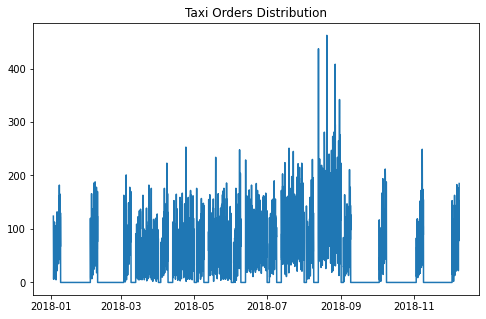

In [12]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(111)
ax1.plot(taxi_oreders)
plt.title('Taxi Orders Distribution');

### Trends and Seasonality

In [13]:
decomposed = seasonal_decompose(taxi_oreders)

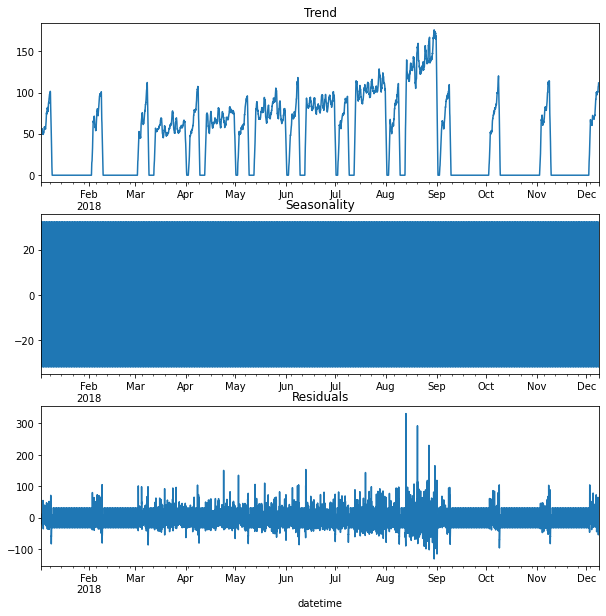

In [14]:
plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals');

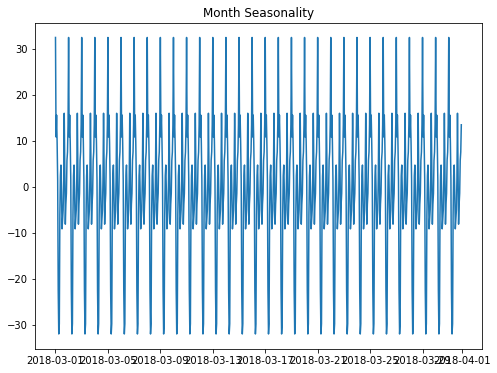

In [15]:
# one month view
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed.seasonal['2018-03-01':'2018-03-31'])
plt.title('Month Seasonality');

Text(0.5, 1.0, 'Weekly Seasonality')

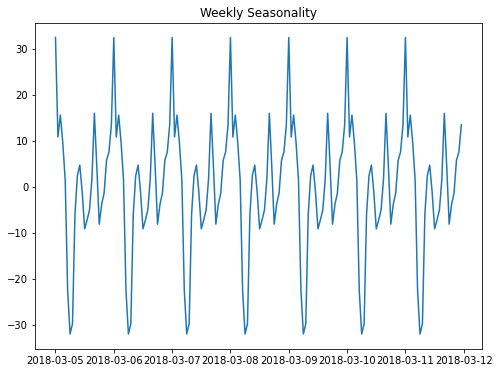

In [16]:
# one week view
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed.seasonal['2018-03-05':'2018-03-11'])
plt.title('Weekly Seasonality')

**We can observe daily seasonality in the week picture**

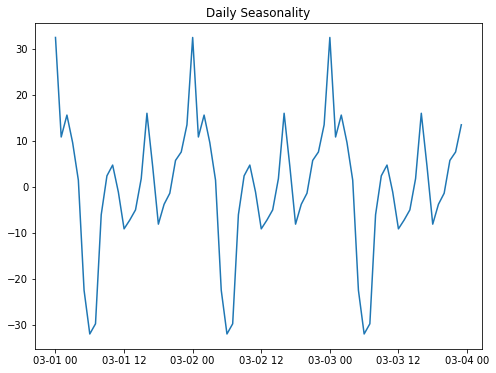

In [17]:
# three days view
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed.seasonal['2018-03-01':'2018-03-03'])
plt.title('Daily Seasonality');

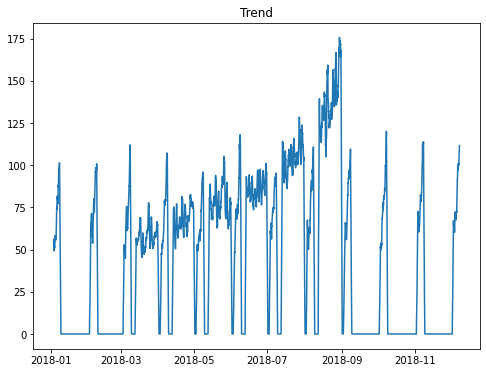

In [18]:
# Whole period trend
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed.trend)
plt.title('Trend');

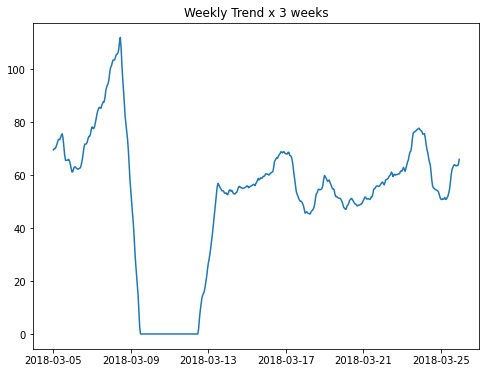

In [19]:
# Looking at a period of three weeks
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed.trend['2018-03-05':'2018-03-25'])
plt.title('Weekly Trend x 3 weeks');

**Findings:**

We can observe a weekly trend, that in a longer time frame turns into a seasonality - there is a pattern change in the number of orders depending on the day of the week

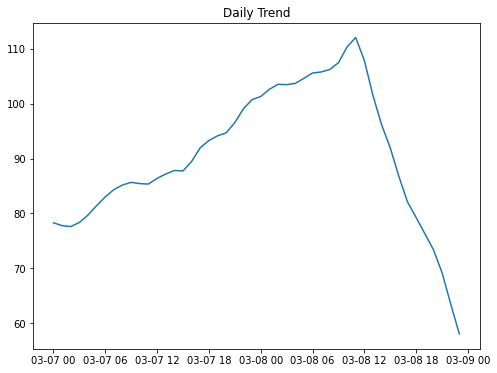

In [20]:
# two days view
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed.trend['2018-03-07':'2018-03-08'])
plt.title('Daily Trend');

**In this graph, daily trending is not recognized**

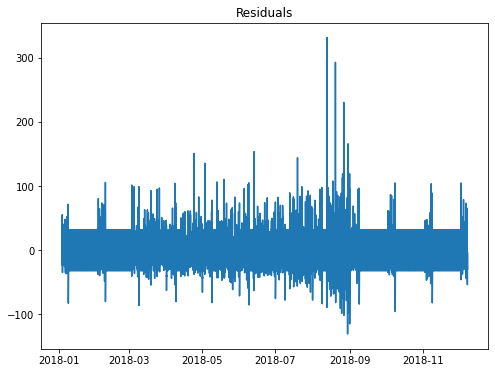

In [21]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed.resid)
plt.title('Residuals');

**Findings:**
    
The graph of residuals shows quite constand mean and variance. 

A change is observed on the last month, when the variance is growing and we see many exceptionaly high numbers

### Day aggregation

In [22]:
data_day = taxi_oreders['num_orders'].resample('1D').sum()
decomposed_day = seasonal_decompose(data_day)

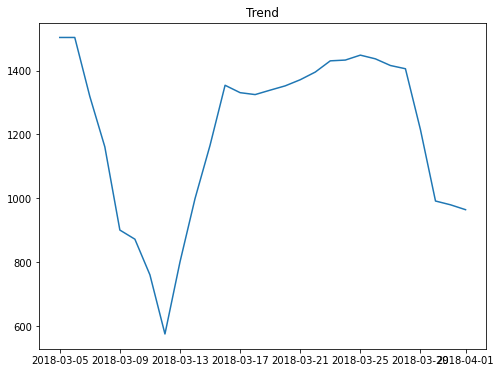

In [23]:
# four weeks view
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed_day.trend['2018-03-05':'2018-04-01'])
plt.title('Trend');

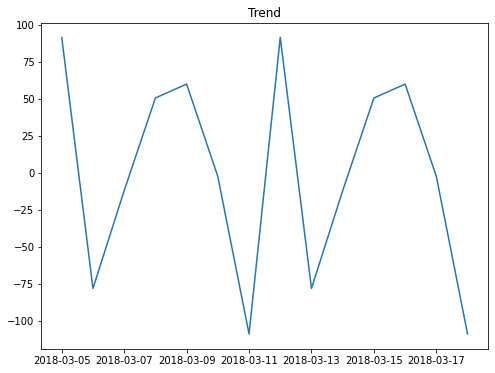

In [24]:
# Two weeks view
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(decomposed_day.seasonal['2018-03-05':'2018-03-18'])
plt.title('Trend');

### Is the data stationary?

In [25]:
df_to_plot = taxi_oreders.copy()

In [26]:
df_to_plot.head()

,num_orders
datetime,
2018-01-03 00:00:00,124
2018-01-03 01:00:00,85
2018-01-03 02:00:00,71
2018-01-03 03:00:00,66
2018-01-03 04:00:00,43


In [27]:
# Looking for the average orders number and standard devietion for 24 hours period
df_to_plot['rolling_mean'] = df_to_plot['num_orders'].rolling(12).mean()
df_to_plot['std'] = df_to_plot['num_orders'].rolling(12).std()

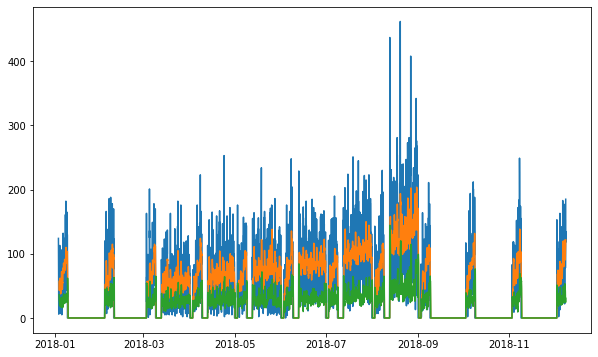

In [28]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.plot(df_to_plot);

**Findings:**

The data is not stationary: We can see that the mean changes over time. 
The standard devietion, however does not change over time, what make this process's prediction feasible**

### Data Shift

In [29]:
data_diff = taxi_oreders.copy()
data_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8160 entries, 2018-01-03 00:00:00 to 2018-12-08 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  8160 non-null   int64
dtypes: int64(1)
memory usage: 127.5 KB


In [30]:
data_diff -= data_diff.shift()

In [31]:
data_diff.head()

,num_orders
datetime,
2018-01-03 00:00:00,NaN
2018-01-03 01:00:00,-39.0
2018-01-03 02:00:00,-14.0
2018-01-03 03:00:00,-5.0
2018-01-03 04:00:00,-23.0


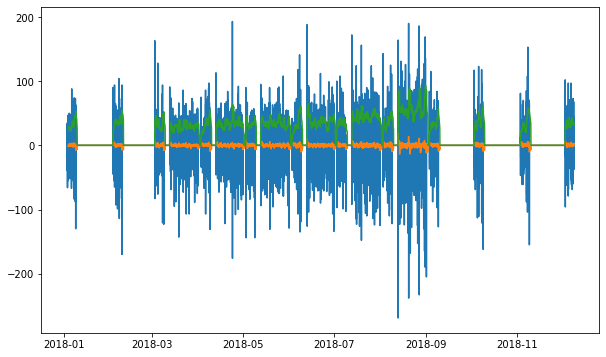

In [32]:
data_diff['mean'] = data_diff['num_orders'].rolling(24).mean()
data_diff['std'] = data_diff['num_orders'].rolling(24).std()

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ax1.plot(data_diff);

**Findings:**

We can see in this graph how the standard deviation is very stable, and again how the average (positive) change is growing 

## Training

In [33]:
# Splitting the data to train and test data sets
train, test = train_test_split(taxi_oreders, shuffle=False, test_size=0.1)

train = train.dropna()
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [34]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-01-03 00:00:00 2018-11-04 23:00:00
2018-11-05 00:00:00 2018-12-08 23:00:00


### Model sanity check forecasting without training

#### Constant model: median

In [35]:

pred_median = np.ones(target_test.shape) * target_train.median()

print('MAE:', mean_absolute_error(target_test,pred_median))
print('RMSE:', math.sqrt(mean_squared_error(target_test, pred_median)))

MAE: 41.33455882352941
RMSE: 46.3045253579761


#### Previous value

In [36]:
# This model predicts based on the previous value
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print('MAE:', mean_absolute_error(target_test, pred_previous))
print('RMSE:', math.sqrt(mean_squared_error(target_test, pred_previous)))

MAE: 8.381127450980392
RMSE: 20.90691906297727


The previous value model provides better results then the constant model!

### Creating Features

In [37]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [38]:
# I have set leg=4, rolling window = 3 after few itterations of tests
df = taxi_oreders.copy()
max_lag = 24
rolling_mean_size = 4
df = make_features(df, max_lag, rolling_mean_size)

In [39]:
df.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00,124,1,3,0,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 01:00:00,85,1,3,1,2,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 02:00:00,71,1,3,2,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 03:00:00,66,1,3,3,2,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 04:00:00,43,1,3,4,2,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5


In [40]:
# Checking target-features correlations
df.drop('num_orders', axis=1).apply(lambda feature: feature.corr(taxi_oreders['num_orders']))

month           0.010504
day             0.081964
hour            0.001953
dayofweek      -0.018099
lag_1           0.842608
lag_2           0.773479
lag_3           0.706729
lag_4           0.676033
lag_5           0.664513
lag_6           0.670337
lag_7           0.684628
lag_8           0.687885
lag_9           0.666370
lag_10          0.658193
lag_11          0.672970
lag_12          0.674090
lag_13          0.666188
lag_14          0.640865
lag_15          0.626252
lag_16          0.633265
lag_17          0.624715
lag_18          0.605516
lag_19          0.599455
lag_20          0.595316
lag_21          0.607358
lag_22          0.644244
lag_23          0.688417
lag_24          0.720026
rolling_mean    0.814317
dtype: float64

In [41]:
# Splitting the new df to train and test sets
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
train_target = train['num_orders']
train_features = train.drop('num_orders', axis=1)
test_target = test['num_orders']
test_features = test.drop('num_orders', axis=1)

#### Linear regression

In [42]:
# Linear regression
lr = LinearRegression()
lr.fit(train_features, train_target)
train_predictions = lr.predict(train_features)

print('Logistic regression')
print("MAE for the training set:", mean_absolute_error(train_target, train_predictions))
print('RMSE:', math.sqrt(mean_squared_error(train_target, train_predictions)))

Logistic regression
MAE for the training set: 15.867901810007856
RMSE: 25.845659377593734


#### Random forest

In [43]:
# Runing GridSearchCV for hyperparameters optimization
model = RandomForestRegressor(random_state=12345)
tss = TimeSeriesSplit(n_splits=5)
# Let's optimize the model by finding the best hyperparameters
params = {'max_depth': range(5, 25, 5), 'min_samples_split' : range(3, 15, 3), 'n_estimators': range(10, 70, 20)}

rfr = GridSearchCV(model,  param_grid=params, cv=tss, scoring = 'neg_mean_squared_error')
rfr.fit(train_features, train_target)

#cv_model_evaluation(rfr)
print(abs(rfr.best_score_), rfr.best_params_)

686.1215231058037 {'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 50}


In [44]:
# Training the model with optimized hyperparameters
rfr = RandomForestRegressor(max_depth= 15, min_samples_split= 6, n_estimators= 50, random_state=12345)
rfr.fit(train_features, train_target)
train_predictions = rfr.predict(train_features)

print('RandomForest')
print("MAE for the training set:", mean_absolute_error(train_target, train_predictions))
print('RMSE:', math.sqrt(mean_squared_error(train_target, train_predictions)))

RandomForest
MAE for the training set: 5.407031236156448
RMSE: 10.409043522495653


#### Cat Boost regressor 

In [45]:
# Runing GridSearchCV for hyperparameters optimization
model = CatBoostRegressor(loss_function="RMSE", iterations=20, random_seed=12345, verbose=20) 
tss = TimeSeriesSplit(n_splits=5)
params = {'depth': range(4, 10, 2), 'learning_rate': np.arange(.05, .1, .1), 'iterations': range(10, 40, 10)}

cbr = GridSearchCV(model, param_grid=params, cv=tss, n_jobs=-1, scoring='neg_mean_squared_error')
cbr.fit(train_features, train_target)

#cv_model_evaluation(cbr)
print(abs(cbr.best_score_), cbr.best_params_)

0:	learn: 52.0157046	total: 141ms	remaining: 4.09s
20:	learn: 30.1434735	total: 235ms	remaining: 101ms
29:	learn: 26.6804374	total: 277ms	remaining: 0us
1101.624798513777 {'depth': 6, 'iterations': 30, 'learning_rate': 0.05}


In [46]:
# Training the model with optimized hyperparameters
cbr = CatBoostRegressor(depth=6, iterations=30, learning_rate=0.05 ,random_seed=12345, verbose=10)
cbr.fit(train_features, train_target) 
train_predictions = cbr.predict(train_features)

print('CatBoost regressor')
print("MAE for the training set:", mean_absolute_error(train_target, train_predictions))
print('RMSE:', math.sqrt(mean_squared_error(train_target, train_predictions)))

0:	learn: 52.0157046	total: 4.28ms	remaining: 124ms
10:	learn: 37.7783402	total: 50.3ms	remaining: 86.8ms
20:	learn: 30.1434735	total: 96.4ms	remaining: 41.3ms
29:	learn: 26.6804374	total: 137ms	remaining: 0us
CatBoost regressor
MAE for the training set: 18.75227535554261
RMSE: 26.680437401223696


#### Light GBM Regressor

In [47]:
# LGBMRegressor
lgbm = LGBMClassifier(random_state=12345) 
lgbm.fit(train_features, train_target) 
train_predictions = lgbm.predict(train_features)

print('LGBMRegressorr')
print("MAE for the training set:", mean_absolute_error(train_target, train_predictions))
print('RMSE:', math.sqrt(mean_squared_error(train_target, train_predictions)))

LGBMRegressorr
MAE for the training set: 31.6094262295082
RMSE: 52.23969425386891


## Testing

In [48]:
# Linear Regression
test_predictions = lr.predict(test_features)

print("MAE on test: ", mean_absolute_error(test_target, test_predictions))
print('RMSE on test:', math.sqrt(mean_squared_error(test_target, test_predictions)))

MAE on test:  9.371455335682358
RMSE on test: 18.220413780948242


In [49]:
# Random Forest
test_predictions = rfr.predict(test_features)

print("MAE on test: ", mean_absolute_error(test_target, test_predictions))
print('RMSE on test:', math.sqrt(mean_squared_error(test_target, test_predictions)))

MAE on test:  5.654770242757465
RMSE on test: 14.354350927260619


In [50]:
# CatBoost
test_predictions = cbr.predict(test_features) 

print("MAE on test: ", mean_absolute_error(test_target, test_predictions))
print('RMSE on test:', math.sqrt(mean_squared_error(test_target, test_predictions)))

MAE on test:  14.811616956656522
RMSE on test: 20.361221298203844


In [51]:
# LGBMRegressor
test_predictions = lgbm.predict(test_features) 

print("MAE on test: ", mean_absolute_error(test_target, test_predictions))
print('RMSE on test:', math.sqrt(mean_squared_error(test_target, test_predictions)))

MAE on test:  17.207107843137255
RMSE on test: 38.16744262418676


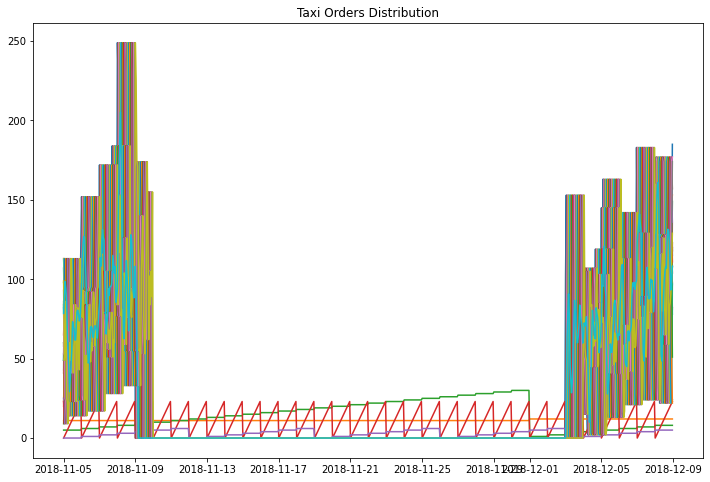

In [52]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
ax1.plot(test)
plt.title('Taxi Orders Distribution');

**Summary:**

We receicved data of 6 months taxi orders in a 10 minutes resolution. our goal was to build a model that can predict future orders, the prediction horizon = 1 hour.

**Analysis**
Using decomposition method, we analysed the data in few different resolutions (hour, day) and different time frames. We found seasonality in the number of orders during the hours of the day.
We didn't find seasonality in number of orders during weeks days.

We also found a trend of increasing orders over all the period. 

**Training**
We created new features: calendar: Month, Day, Day of week, Hour; lag and rolling mean. We tried few sets of max lags and rolling mean.

For sanity check we trained two constant models: median and previous value. the second one provided better results (RMSE 58.85 on train data).

Then we traind 4 different models. for 2 of them we performed hyperparameters tuning using GridSearchCV

Finaly, we tested all the models performance on test data.

Models results:

**Linear regression:** train RMSE:30.47         test RMSE:53.05

**RandomFores:**       train RMSE:14.00         test RMSE:45.89

**CatBoost:**          train RMSE:25.44         test RMSE:61.71

**LGBMRegressor:**     train RMSE:40.62         test RMSE:80.49

Random forest model produced the best predictions. RMSE = 45.90   
Yet, we had high overfitting.
(LGBMR was the worst, but it also wasn't tuned...)